# GeoCLEWs

**Revised code:** [Yalda Saedi](https://github.com/Ysaedi) and [Ronnice Chepkoech](https://github.com/Ronnice-Chepkoech) <br />
**Supervision:** [Taco Niet](https://github.com/tniet) & [Benard Alunda](https://www.linkedin.com/in/bernard-alunda-b78148170) <br />

**Funding** [Mitacs](https://www.mitacs.ca/en), [Catalyste+](https://www.catalysteplus.org/) and [Global affairs Canada](https://www.international.gc.ca)

Original code: [Alexandros Korkovelos](https://github.com/akorkovelos) <br />
Supervision: [Abhishek Shivakumar](https://github.com/abhishek0208) & [Thomas Alfstad]() <br />

---------------------------

## Summary

GeoCLEWs is a versatile open-source script that offers a wide range of useful features for both developers and users. The script streamlines the detailed land and water processing steps required for Climate Land Energy Water systems (CLEWs) modelling. It is designed to efficiently collect, modify, and process  high-resolution land and water data from Global Agro-ecological Zones (GAEZ v4) database in an automated manner. GeoCLEWs processes agro-climatic potential yield, crop water deficit, crop evapotranspiration, precipitation, and land cover datasets.

This notebook is build upon the [CLEWs GIS Processing notbook](https://github.com/akorkovelos/un-clews-gis-work/blob/main/CLEWs%20GIS%20Processing.ipynb), which is rendered non-functional due to its incompatibility with the latest version of the GAEZ database. Although the original code serving as a valuable starting point, it has been subject to significant revisions and improvements aimed at increasing its efficiency and ease of use.


At the beginning of the script, users can input and tailor the configuration to align with their project's unique requirements. Once the necessary inputs are provided, GeoCLEWs will automatically execute the subsequent steps, including the data collection from FAOSTAT (Food and Agriculture Organization of the United Nation) and retrieving high-resolution raster files from GAEZ v4. Additionally, it implements geographical and spatial clustering to detect cross-regional agro-ecological similarities and generate detailed land and water statistics.

This notebook performs six main analytical processes:

- **Part 1**: Initialization and configuration.
- **Part 2**: FAOSTAT and GAEZ data collection and preparation.
- **Part 3**: Generating land cells.
- **Part 4**: Geospatial attributes extraction to land cells.
- **Part 5**: Spatial clustering
- **Part 6**: Calculating key summary statistics generate outputs for further use in CLEWs modelling.

Each part below is accompanied by a more detailed explanation of the involved processing steps.

# Part 1 : Initialization and Configuration

# 1.1. Importing Essential Modules 

To begin, it is necessary to import the required modules/libraries. For more information on the environment setup, please consult the README file. 

In [1]:
# Importing necessary Python modules or libraries

# Numerical
import numpy as np
import pandas as pd
import requests

# Spatial
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
from geojson import Feature, Point, FeatureCollection
import json
from shapely.geometry import Polygon, Point
import gdal
from pyproj import CRS
from rasterio.mask import mask
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering


#Plotting
import ipywidgets
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import display, Markdown, HTML
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from sklearn.cluster import KMeans

# System & Other
import time
import os
import datetime
start_time = time.time()


# 1.2. User Configuration  
This is the only part where the user needs to input values. The rest of the process will be automatically run based on the provided inputs. The code is designed with flexibility, allowing users to make changes and take advantage of customized settings at any time during the execution.


In [2]:
# Provide specifications for the project 

Full_name = "Kenya"                   # Specify the full name of the country you wish to analyze (e.g. Kenya).

RCP = "RCP4.5"                        # Choose your preferred RCP (Representative Concentration Pathway) from the available options: RCP2.6, RCP4.5, RCP6.0, RCP8.5.


admin_level = 1                       # 0 for national processing, admin level 0.
                                      # 1 for processing at admin level 1.


#Aggregating regions    
aggregate = True                      # If the admin_level is 1 or higher, you can select specific regions, group them together, and generate statistical results for these regions as one aggregated area. It's important that the administrative boundary of the selected regions matches the setup admin_level.                            
                                      # "False" indicates no aggregation, "True" performs aggregation. 
                                      # Input the first 3 letter of selected regions for aggregation e.g. "TAI" refers to Taita Taveta county in Kenya that can be selected to group if admin_level=1.
aggregate_region = ["GRC", "TUR", "WAJ", "MAN", "VIH", "TRA", "WES", "UAS","MIG", "BAR", "BOM", "BUN", "BUS", "ELG", "EMB", "GAR", "HOM", "ISI", "KAJ","KAK", "KER", "KIA", "KIL", "KIR", "KIS", "KIT", "KSU", "KWA", "LAI","LAM", "MAC", "MAK", "MAR", "MER", "MIG", "MOM", "MUR", "NAI","NAK", "NAN", "NAR", "NYA", "NYD", "NYE", "SAM", "SIA", "TAN","THA"]
   
                                      #(This is for BC + AL in Canada e.g)

                         


## Coordinate and projection systems
crs_WGS84 = CRS("EPSG:4326")          # For analysis, the original WGS84 coordinate system is used. 
crs_proj = CRS("EPSG:21037")          # Please provide proper projection system based on the geographical location of the selected country. 
                                      # In this example EPSG 21037 refers to a specific projection system called the "Kenya Mapping Grid".
                                      # More info: http://epsg.io/ 
# Get the current year
from datetime import datetime
current_year = datetime.now().year

# Define the parameters covering the entire period from 1981 to 2100
parameters = {"start_date": "1981-01-01", "end_date": "2100-12-31"}

# Print the parameters
print("Selected Parameters:")
print(parameters)

Selected Parameters:
{'start_date': '1981-01-01', 'end_date': '2100-12-31'}


## 1.3. Directory Initialization and Structure

For easier replication of the code you may used the following directory structure:

* **~root/Data/input**    (a directory where your input data)
* **~root/global_raster_input**   (directory for GAEZ raster layers with global coverage.  Precipitation and land cover rasters have already downloaded in the global_raster_input while agro-climatic potential yield, crop water deficit, and crop evapotranspiration with global coverage will be downloaded automatically in the following steps based on user input)
* **~root/cropped_raster_input** (a directory for cropped GAEZ global raster data based on administraty boundry of selected country to reduce computational complexity)

Results will be store in two automatically generated directories:
* **~root/Data/output**   (directory for general output)
* **~root/Data/output/summary_stats**   (a directory where the tabular outputs data and graphs are stored)

**Note!** In case you decide to use a different structure please revise the code below.

In [3]:
# Directories
ROOT_DIR = os.path.abspath(os.curdir)
data_folder = "Data"

in_path = os.path.join(ROOT_DIR, data_folder + "\\"+ 'input')
in_path_raster = os.path.join(ROOT_DIR, 'global_raster_input')
out_path_raster = os.path.join(ROOT_DIR, 'cropped_raster_input')

if not os.path.exists(out_path_raster):
    try:
        os.makedirs(out_path_raster)
    except OSError as exc: 
        if exc.errno != errno.EEXIST:
            raise

out_path = os.path.join(ROOT_DIR, data_folder + "\\"+ 'output')
if not os.path.exists(out_path):
    try:
        os.makedirs(out_path)
    except OSError as exc: 
        if exc.errno != errno.EEXIST:
            raise
            
            
summary_stats_path = out_path + "\\" + "summary_stats"
if not os.path.exists(summary_stats_path):
    try:
        os.makedirs(summary_stats_path)
    except OSError as exc:                                        
        if exc.errno != errno.EEXIST:
            raise


out_path_dendrogram =out_path + "\\" + "dendrogram_graph"
if not os.path.exists(out_path_dendrogram):
    try:
        os.makedirs(out_path_dendrogram)
    except OSError as exc:                                         # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise
            
out_path_elbow = out_path + "\\" + "elbow_graph"
if not os.path.exists(out_path_elbow):
    try:
        os.makedirs(out_path_elbow)
    except OSError as exc:                                         # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise
            
out_path_clustering = out_path + "\\" + "spatial_clustering"
if not os.path.exists(out_path_clustering):
    try:
        os.makedirs(out_path_clustering)
    except OSError as exc:                                         # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise
            

# 3 letter ISO code of the selected country
code = pd.read_csv('Country_code.csv')                            # More info: https://www.nationsonline.org/oneworld/country_code_list.htm                                        
code_name = code[code['Full_name']== Full_name]
country_name = code_name.iloc[0]['country_code']            
            
# supporting vector point name
shp_nm = "{}_data.shp".format(country_name)
    
#administrative boundary
admin0_nm = '{}_adm0.shp'.format(country_name)                     # administrative boundaries - national analysis

# Name of final result file
output_nm = "{}_vector_admin{}_land_cells".format(country_name, admin_level)
result_nm = "{}_vector_admin{}_land_cells_with_attributes".format(country_name, admin_level)

# Part 2 : FAOSTAT and GAEZ Data Collection and Preparation

## 2.1. FAOSTAT Collection and Preparation
Finding top 10 crops in terms of harvested area from the latest statistical database provided by Food and Agriculture Organization of the United Nations (FAOSTAT).

### 2.1.1. Retrieve Top 10 Crops

In [4]:
# Read the FAOSTAT file
data = pd.read_csv('FAOSTAT_2020.csv')
filtered_data = data[data['Area'] == Full_name]                

# Sorting based on the harvested area in descending order and get top 10 rows
# Retrieve data according to the user-defined country
top_10_values = filtered_data.nlargest(10, 'Value')
all_crops = top_10_values['Item'].tolist() 

main_crops= all_crops[:5]
other_crops = all_crops[5:]

display(Markdown(' **Top 5 crops considering harvested area are:** {}'.format(main_crops)))
display(Markdown(' **Crops ranked from six to ten in the top 10 FAO dataset are:** {}'.format(other_crops)))

 **Top 5 crops considering harvested area are:** ['Maize (corn)', 'Beans, dry', 'Tea leaves', 'Cow peas, dry', 'Sorghum']

 **Crops ranked from six to ten in the top 10 FAO dataset are:** ['Other pulses n.e.c.', 'Potatoes', 'Pigeon peas, dry', 'Wheat', 'Coffee, green']

### 2.1.2. FAOSTAT Standardizing

In [5]:
# FAO correction: 3 letter naming convention per crop considering CLEWs naming format

Crop_code = pd.read_csv('Crop_code.csv')
crop_name = []  

for item in main_crops:
    matching_rows = Crop_code[Crop_code['Name']==item]
    
    if not matching_rows.empty:
        crop_name.extend(matching_rows['Code'].tolist())  

other_crop_name = []  

for item in other_crops:
    matching_rows = Crop_code[Crop_code['Name']==item]
    
    if not matching_rows.empty:
        other_crop_name.extend(matching_rows['Code'].tolist())  


#Adding "prc" refering to annual precipitation
crop_name = crop_name + ["prc"]

display(Markdown(' **Based on 3-letter naming, the main crop list from the FAOSTAT is :** {}'.format(crop_name)))
display(Markdown(' **Based on 3-letter naming, additional crop list from the FAOSTAT is :** {}'.format(other_crop_name)))


 **Based on 3-letter naming, the main crop list from the FAOSTAT is :** ['MZE', 'BEA', 'TEA', 'COW', 'SOR', 'prc']

 **Based on 3-letter naming, additional crop list from the FAOSTAT is :** ['PTW', 'PIG', 'WHE', 'COF']

## 2.2. GAEZ Data Collection and Preparation

GeoCLEWs collects TIFF data from the Global Agro-Ecological Zones data portal for the following variables: agro-climatic potential yield, crop water deficit, and crop evapotranspiration. Precipitation, and land cover have already downloaded in the directory.

In [6]:
#Import agro-climatic potential yield 
yld_High_input_2071_2100 = pd.read_csv('GAEZ_yld_High_Input_2071_2100.csv')
yld_High_input_2041_2070 = pd.read_csv('GAEZ_yld_High_Input_2041_2070.csv')
yld_High_input_2011_2040 = pd.read_csv('GAEZ_yld_High_Input_2011_2040.csv')
yld_High_input_1981_2010 = pd.read_csv('GAEZ_yld_High_Input_1981_2010.csv')
yld_Low_input_1981_2010 = pd.read_csv('GAEZ_yld_Low_Input_1981_2010.csv')

#Import crop water deficit
cwd_High_input_2071_2100 = pd.read_csv('GAEZ_cwd_High_Input_2071_2100.csv')
cwd_High_input_2041_2070 = pd.read_csv('GAEZ_cwd_High_Input_2041_2070.csv')
cwd_High_input_2011_2040 = pd.read_csv('GAEZ_cwd_High_Input_2011_2040.csv')
cwd_High_input_1981_2010 = pd.read_csv('GAEZ_cwd_High_Input_1981_2010.csv')
cwd_Low_input_1981_2010 = pd.read_csv('GAEZ_cwd_Low_Input_1981_2010.csv')

#Import crop evapotranspiration 
evt_High_input_2071_2100 = pd.read_csv('GAEZ_evt_High_Input_2071_2100.csv')
evt_High_input_2041_2070 = pd.read_csv('GAEZ_evt_High_Input_2041_2070.csv')
evt_High_input_2011_2040 = pd.read_csv('GAEZ_evt_High_Input_2011_2040.csv')
evt_High_input_1981_2010 = pd.read_csv('GAEZ_evt_High_Input_1981_2010.csv')
evt_Low_input_1981_2010 = pd.read_csv('GAEZ_evt_Low_Input_1981_2010.csv')

# Define a function to extract the start and end years from a CSV file
def extract_time_period(filename):
    data = pd.read_csv(filename)
    start_year = data['Time Period'].str.split('-', expand=True)[0].astype(int)
    end_year = data['Time Period'].str.split('-', expand=True)[1].astype(int)
    return start_year, end_year

### 2.2.1. GAEZ Data Acquisition

### 2.2.2. GAEZ Data Preprocessing

In [7]:
#Add a new column for water supply
yld_High_input_2071_2100['New Water Supply'] = yld_High_input_2071_2100['Water Supply'].apply(lambda x: 'Irrigation' if 'irrigation' in x else 'Rain-fed')
yld_High_input_2041_2070['New Water Supply'] = yld_High_input_2041_2070['Water Supply'].apply(lambda x: 'Irrigation' if 'irrigation' in x else 'Rain-fed')
yld_High_input_2011_2040['New Water Supply'] = yld_High_input_2011_2040['Water Supply'].apply(lambda x: 'Irrigation' if 'irrigation' in x else 'Rain-fed')
yld_High_input_1981_2010['New Water Supply'] = yld_High_input_1981_2010['Water Supply'].apply(lambda x: 'Irrigation' if 'irrigation' in x else 'Rain-fed')
yld_Low_input_1981_2010['New Water Supply'] = yld_Low_input_1981_2010['Water Supply'].apply(lambda x: 'Irrigation' if 'irrigation' in x else 'Rain-fed')

cwd_High_input_2071_2100['New Water Supply'] = cwd_High_input_2071_2100['Water Supply'].apply(lambda x: 'Irrigation' if 'irrigation' in x else 'Rain-fed')
cwd_High_input_2041_2070['New Water Supply'] = cwd_High_input_2041_2070['Water Supply'].apply(lambda x: 'Irrigation' if 'irrigation' in x else 'Rain-fed')
cwd_High_input_2011_2040['New Water Supply'] = cwd_High_input_2011_2040['Water Supply'].apply(lambda x: 'Irrigation' if 'irrigation' in x else 'Rain-fed')
cwd_High_input_1981_2010['New Water Supply'] = cwd_High_input_1981_2010['Water Supply'].apply(lambda x: 'Irrigation' if 'irrigation' in x else 'Rain-fed')
cwd_Low_input_1981_2010['New Water Supply'] = cwd_Low_input_1981_2010['Water Supply'].apply(lambda x: 'Irrigation' if 'irrigation' in x else 'Rain-fed')

evt_High_input_2071_2100['New Water Supply'] = evt_High_input_2071_2100['Water Supply'].apply(lambda x: 'Irrigation' if 'irrigation' in x else 'Rain-fed')
evt_High_input_2041_2070['New Water Supply'] = evt_High_input_2041_2070['Water Supply'].apply(lambda x: 'Irrigation' if 'irrigation' in x else 'Rain-fed')
evt_High_input_2011_2040['New Water Supply'] = evt_High_input_2011_2040['Water Supply'].apply(lambda x: 'Irrigation' if 'irrigation' in x else 'Rain-fed')
evt_High_input_1981_2010['New Water Supply'] = evt_High_input_1981_2010['Water Supply'].apply(lambda x: 'Irrigation' if 'irrigation' in x else 'Rain-fed')
evt_Low_input_1981_2010['New Water Supply'] = evt_Low_input_1981_2010['Water Supply'].apply(lambda x: 'Irrigation' if 'irrigation' in x else 'Rain-fed')

### 2.2.3. GAEZ Data Standardizing

In [8]:
        
def GAEZ_naming (dataset, filename):
    
    dataset['New Crop'] = dataset['Crop'].apply(lambda x: Crop_code.loc[Crop_code['GAEZ_name'] == x, 'Code'].values[0] if x in Crop_code['GAEZ_name'].values else 'Nan')
    dataset.to_csv(filename, index=False)
    
GAEZ_naming (yld_High_input_2071_2100, 'New_yld_High_input_2071_2100.csv')
GAEZ_naming (yld_High_input_2041_2070, 'New_yld_High_input_2041_2070.csv')
GAEZ_naming (yld_High_input_2011_2040, 'New_yld_High_input_2011_2040.csv')
GAEZ_naming (yld_High_input_1981_2010, 'New_yld_High_input_1981_2010.csv') 
GAEZ_naming (yld_Low_input_1981_2010, 'New_yld_Low_input_1981_2010.csv') 
GAEZ_naming (cwd_High_input_2071_2100, 'New_cwd_High_input_2071_2100.csv')
GAEZ_naming (cwd_High_input_2041_2070, 'New_cwd_High_input_2041_2070.csv')
GAEZ_naming (cwd_High_input_2011_2040, 'New_cwd_High_input_2011_2040.csv') 
GAEZ_naming (cwd_High_input_1981_2010, 'New_cwd_High_input_1981_2010.csv') 
GAEZ_naming (cwd_Low_input_1981_2010, 'New_cwd_Low_input_1981_2010.csv') 
GAEZ_naming (evt_High_input_2071_2100, 'New_evt_High_input_2071_2100.csv')
GAEZ_naming (evt_High_input_2041_2070, 'New_evt_High_input_2041_2070.csv')
GAEZ_naming (evt_High_input_2011_2040, 'New_evt_High_input_2011_2040.csv')
GAEZ_naming (evt_High_input_1981_2010, 'New_evt_High_input_1981_2010.csv') 
GAEZ_naming (evt_Low_input_1981_2010, 'New_evt_Low_input_1981_2010.csv') 

### 2.2.4. GAEZ Data Filtering according to User Configuration

In [9]:
#filtering in accordance with user-defined RCP 
Filtered_yld_High_input_2071_2100 = yld_High_input_2071_2100[yld_High_input_2071_2100['RCP'] == RCP]
Filtered_yld_High_input_2041_2070 = yld_High_input_2041_2070[yld_High_input_2041_2070['RCP'] == RCP]
Filtered_yld_High_input_2011_2040 = yld_High_input_2011_2040[yld_High_input_2011_2040['RCP'] == RCP]
Filtered_cwd_High_input_2071_2100 = cwd_High_input_2071_2100[cwd_High_input_2071_2100['RCP'] == RCP]
Filtered_cwd_High_input_2041_2070 = cwd_High_input_2041_2070[cwd_High_input_2041_2070['RCP'] == RCP]
Filtered_cwd_High_input_2011_2040 = cwd_High_input_2011_2040[cwd_High_input_2011_2040['RCP'] == RCP]
Filtered_evt_High_input_2071_2100 = evt_High_input_2071_2100[evt_High_input_2071_2100['RCP'] == RCP]
Filtered_evt_High_input_2041_2070 = evt_High_input_2041_2070[evt_High_input_2041_2070['RCP'] == RCP]
Filtered_evt_High_input_2011_2040 = evt_High_input_2011_2040[evt_High_input_2011_2040['RCP'] == RCP]

#filtering based on with user-defined crops
def GAEZ_List(dataframe, crop_list, column):
    List = pd.DataFrame()
    for crop in crop_list:
        if dataframe[column].str.contains(crop).any():
            List = pd.concat([List, dataframe[dataframe[column].str.contains(crop)]])
    return List


Main_yld_High_2071_2100=GAEZ_List(Filtered_yld_High_input_2071_2100, crop_name, "New Crop")
Other_yld_High_2071_2100=GAEZ_List(Filtered_yld_High_input_2071_2100, other_crop_name, "New Crop")
Main_yld_High_2041_2070=GAEZ_List(Filtered_yld_High_input_2041_2070, crop_name, "New Crop")
Other_yld_High_2041_2070=GAEZ_List(Filtered_yld_High_input_2041_2070, other_crop_name, "New Crop")
Main_yld_High_2011_2040=GAEZ_List(Filtered_yld_High_input_2011_2040, crop_name, "New Crop")
Other_yld_High_2011_2040=GAEZ_List(Filtered_yld_High_input_2011_2040, other_crop_name, "New Crop")
Main_yld_High_1981_2010=GAEZ_List(yld_High_input_1981_2010, crop_name, "New Crop")
Other_yld_High_1981_2010=GAEZ_List(yld_High_input_1981_2010, other_crop_name, "New Crop")
Main_yld_Low_1981_2010=GAEZ_List(yld_Low_input_1981_2010, crop_name, "New Crop")
Other_yld_Low_1981_2010=GAEZ_List(yld_Low_input_1981_2010, other_crop_name, "New Crop")

Main_cwd_High_2071_2100=GAEZ_List(Filtered_cwd_High_input_2071_2100, crop_name, "New Crop")
Other_cwd_High_2071_2100=GAEZ_List(Filtered_cwd_High_input_2071_2100, other_crop_name, "New Crop")
Main_cwd_High_2041_2070=GAEZ_List(Filtered_cwd_High_input_2041_2070, crop_name, "New Crop")
Other_cwd_High_2041_2070=GAEZ_List(Filtered_cwd_High_input_2041_2070, other_crop_name, "New Crop")
Main_cwd_High_2011_2040=GAEZ_List(Filtered_cwd_High_input_2011_2040, crop_name, "New Crop")
Other_cwd_High_2011_2040=GAEZ_List(Filtered_cwd_High_input_2011_2040, other_crop_name, "New Crop")
Main_cwd_High_1981_2010=GAEZ_List(cwd_High_input_1981_2010, crop_name, "New Crop")
Other_cwd_High_1981_2010=GAEZ_List(cwd_High_input_1981_2010, other_crop_name, "New Crop")
Main_cwd_Low_1981_2010=GAEZ_List(cwd_Low_input_1981_2010, crop_name, "New Crop")
Other_cwd_Low_1981_2010=GAEZ_List(cwd_Low_input_1981_2010, other_crop_name, "New Crop")

Main_evt_High_2071_2100=GAEZ_List(Filtered_evt_High_input_2071_2100, crop_name, "New Crop")
Other_evt_High_2071_2100=GAEZ_List(Filtered_evt_High_input_2071_2100, other_crop_name, "New Crop")
Main_evt_High_2041_2070=GAEZ_List(Filtered_evt_High_input_2041_2070, crop_name, "New Crop")
Other_evt_High_2041_2070=GAEZ_List(Filtered_evt_High_input_2041_2070, other_crop_name, "New Crop")
Main_evt_High_2011_2040=GAEZ_List(Filtered_evt_High_input_2011_2040, crop_name, "New Crop")
Other_evt_High_2011_2040=GAEZ_List(Filtered_evt_High_input_2011_2040, other_crop_name, "New Crop")
Main_evt_High_1981_2010=GAEZ_List(evt_High_input_1981_2010, crop_name, "New Crop")
Other_evt_High_1981_2010=GAEZ_List(evt_High_input_1981_2010, other_crop_name, "New Crop")
Main_evt_Low_1981_2010=GAEZ_List(evt_Low_input_1981_2010, crop_name, "New Crop")
Other_evt_Low_1981_2010=GAEZ_List(evt_Low_input_1981_2010, other_crop_name, "New Crop")


### 2.2.5. Downloading and Storing GAEZ Raster Files in a clewsy-Compatible Format

In [10]:
def download_URL(dataframe, column, folder_name):
    for index, row in dataframe.iterrows():
        url = str(row[column])
        filename = str(row['New Crop']) + ' ' + ('cwd' if str(row['Name'].split('_')[-1]) == "wde" else 'evt' if str(row['Name'].split('_')[-1]) == "eta" else str(row['Name'].split('_')[-1])) + ' ' + str(row['New Water Supply']) + ' ' + str(row['Input Level'])
        
        # Extract the time period information from the 'Time Period' column of the input data
        time_period = str(row['Time Period'])  # Assuming 'Time Period' is the column containing the time period information
        
        # Append the time period to the filename
        filename_with_time_period = filename + ' ' + time_period
        
        file_path = os.path.join(folder_name, filename_with_time_period + '.tif')
        
        response = requests.get(url)
        
        with open(file_path, 'wb') as file:
            file.write(response.content)
        
        print(f"Downloaded: {filename_with_time_period}")


download_URL(Main_yld_High_2071_2100, 'Download URL', in_path_raster)
download_URL(Other_yld_High_2071_2100, 'Download URL', in_path_raster)
download_URL(Main_yld_High_2041_2070, 'Download URL', in_path_raster)
download_URL(Other_yld_High_2041_2070, 'Download URL', in_path_raster)
download_URL(Main_yld_High_2011_2040, 'Download URL', in_path_raster)
download_URL(Other_yld_High_2011_2040, 'Download URL', in_path_raster)
download_URL(Main_yld_High_1981_2010, 'Download URL', in_path_raster)
download_URL(Other_yld_High_1981_2010, 'Download URL', in_path_raster)
download_URL(Main_yld_Low_1981_2010, 'Download URL', in_path_raster)
download_URL(Other_yld_Low_1981_2010, 'Download URL', in_path_raster)

download_URL(Main_cwd_High_2071_2100, 'Download URL', in_path_raster)
download_URL(Other_cwd_High_2071_2100, 'Download URL', in_path_raster)
download_URL(Main_cwd_High_2041_2070, 'Download URL', in_path_raster)
download_URL(Other_cwd_High_2041_2070, 'Download URL', in_path_raster)
download_URL(Main_cwd_High_2011_2040, 'Download URL', in_path_raster)
download_URL(Other_cwd_High_2011_2040, 'Download URL', in_path_raster)
download_URL(Main_cwd_High_1981_2010, 'Download URL', in_path_raster)
download_URL(Other_cwd_High_1981_2010, 'Download URL', in_path_raster)
download_URL(Main_cwd_Low_1981_2010, 'Download URL', in_path_raster)
download_URL(Other_cwd_Low_1981_2010, 'Download URL', in_path_raster)

download_URL(Main_evt_High_2071_2100, 'Download URL', in_path_raster)
download_URL(Other_evt_High_2071_2100, 'Download URL', in_path_raster)
download_URL(Main_evt_High_2041_2070, 'Download URL', in_path_raster)
download_URL(Other_evt_High_2041_2070, 'Download URL', in_path_raster)
download_URL(Main_evt_High_2011_2040, 'Download URL', in_path_raster)
download_URL(Other_evt_High_2011_2040, 'Download URL', in_path_raster)
download_URL(Main_evt_High_1981_2010, 'Download URL', in_path_raster)
download_URL(Other_evt_High_1981_2010, 'Download URL', in_path_raster)
download_URL(Main_evt_Low_1981_2010, 'Download URL', in_path_raster)
download_URL(Other_evt_Low_1981_2010, 'Download URL', in_path_raster)

Downloaded: MZE yld Irrigation High 2071-2100
Downloaded: MZE yld Rain-fed High 2071-2100
Downloaded: BEA yld Irrigation High 2071-2100
Downloaded: BEA yld Rain-fed High 2071-2100
Downloaded: TEA yld Irrigation High 2071-2100
Downloaded: TEA yld Rain-fed High 2071-2100
Downloaded: COW yld Irrigation High 2071-2100
Downloaded: COW yld Rain-fed High 2071-2100
Downloaded: SOR yld Irrigation High 2071-2100
Downloaded: SOR yld Rain-fed High 2071-2100
Downloaded: PTW yld Irrigation High 2071-2100
Downloaded: PTW yld Rain-fed High 2071-2100
Downloaded: PIG yld Irrigation High 2071-2100
Downloaded: PIG yld Rain-fed High 2071-2100
Downloaded: WHE yld Irrigation High 2071-2100
Downloaded: WHE yld Rain-fed High 2071-2100
Downloaded: COF yld Irrigation High 2071-2100
Downloaded: COF yld Rain-fed High 2071-2100
Downloaded: MZE yld Irrigation High 2041-2070
Downloaded: MZE yld Rain-fed High 2041-2070
Downloaded: BEA yld Irrigation High 2041-2070
Downloaded: BEA yld Rain-fed High 2041-2070
Downloaded

# Part 3: Generating Land Cells

## 3.1. Generating Georeferenced Point Grid from Shapefile
Considering the resolution of GAEZ raster files, it is recommended to set spacing to 0.09 decimal degrees resulting in a detailed land and water analysis.

In [11]:
#create a GeoDataFrame from the attributes and geometry of the shapefile
shapefile = gpd.read_file(in_path + "\\" + shp_nm)
shapefile = shapefile.to_crs(crs_WGS84)

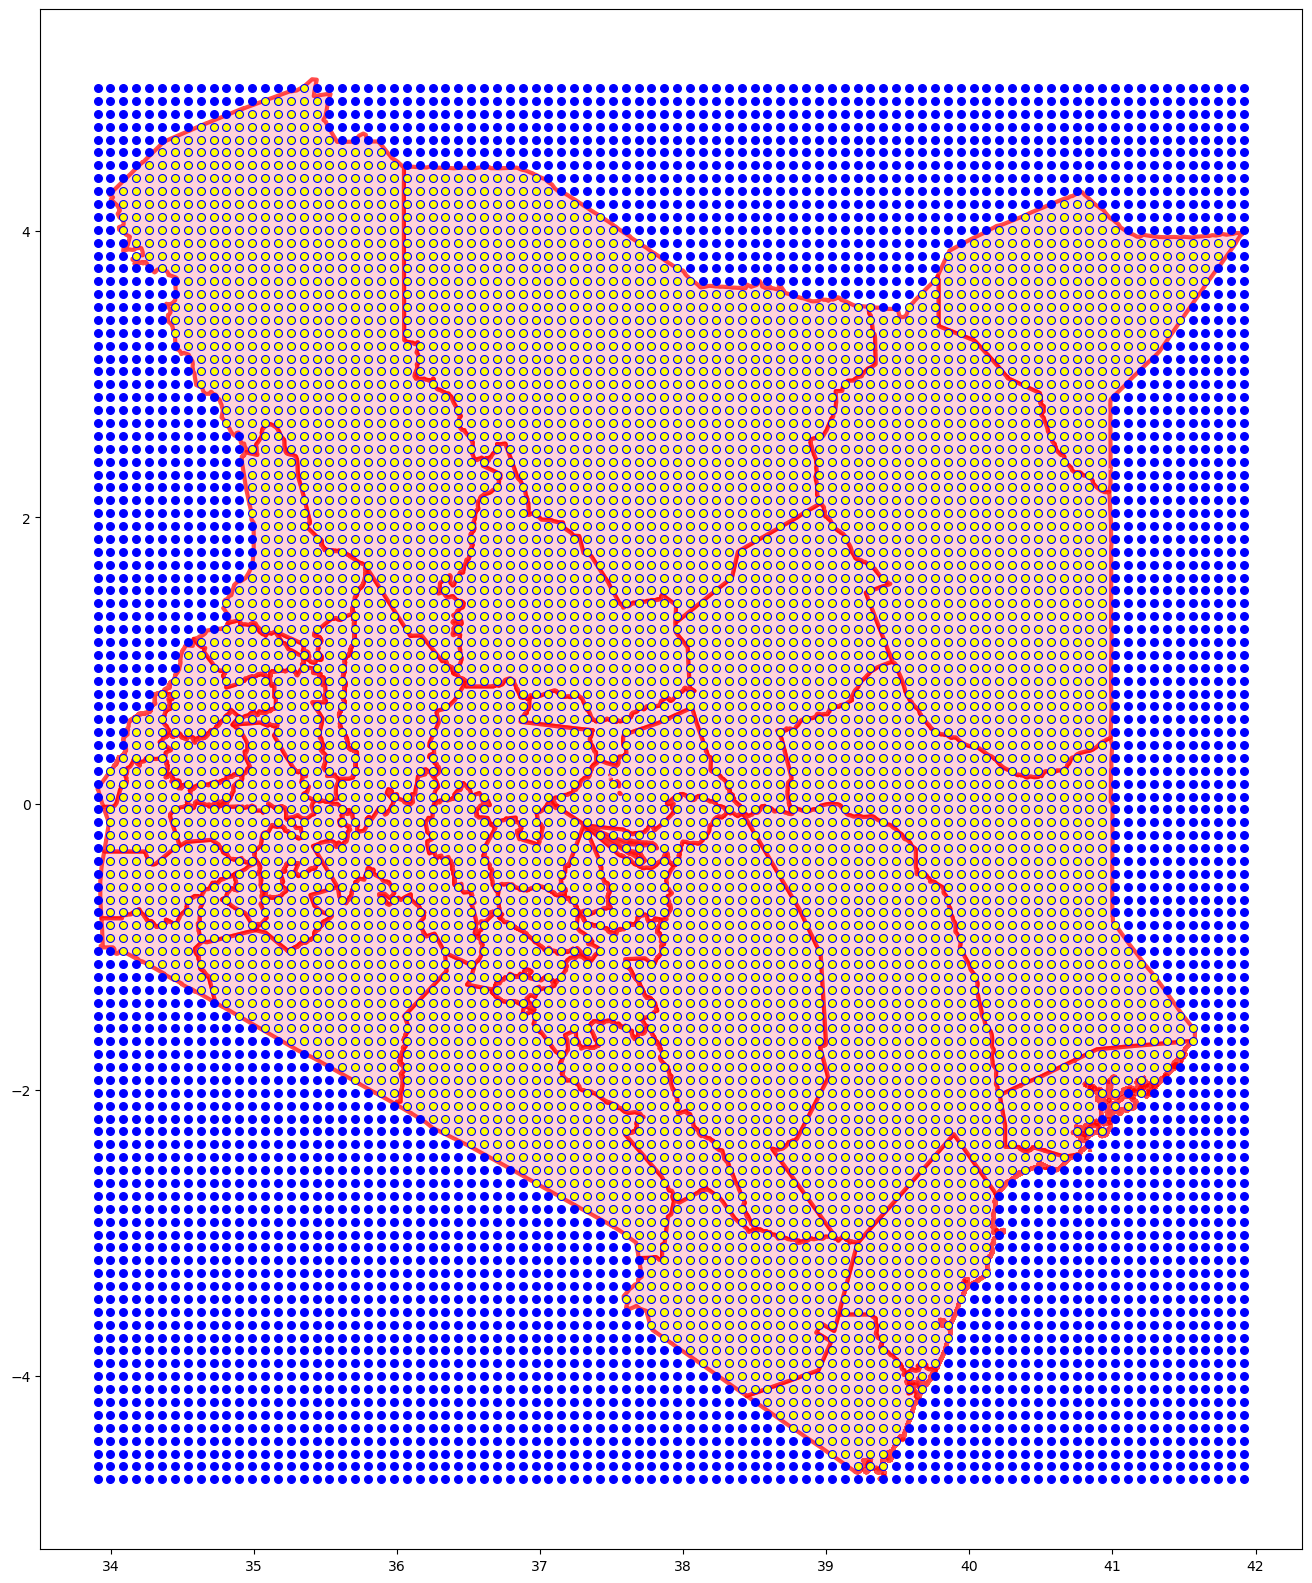

In [12]:
#Creating point grid
spacing = 0.09
xmin, ymin, xmax, ymax = shapefile.total_bounds

xcoords = [i for i in np.arange(xmin, xmax, spacing)]
ycoords = [i for i in np.arange(ymin, ymax, spacing)]

pointcoords = np.array(np.meshgrid(xcoords, ycoords)).T.reshape(-1, 2) 
points = gpd.points_from_xy(x=pointcoords[:,0], y=pointcoords[:,1])
grid = gpd.GeoSeries(points, crs=shapefile.crs)
grid.name = 'geometry'


#only points inside administrative boundary:
gridinside = gpd.sjoin(gpd.GeoDataFrame(grid), shapefile[['geometry']], how="inner")

#Plot georeferenced point grid
fig, ax = plt.subplots(figsize=(20, 20))
shapefile.plot(ax=ax, alpha=0.7, color="pink", edgecolor='red', linewidth=3)
grid.plot(ax=ax, markersize=30, color="blue")
gridinside.plot(ax=ax, markersize=15, color="yellow")
file_path = os.path.join(out_path, "{}_PointGrid.png".format(country_name))
plt.savefig(file_path)

## 3.2. Converting Points to Polygons

A regular grid point is created across the entire area of interest in the previous step. Georeferenced points have unique latitude and longitude. In this step,  square buffer-based polygons are created around each point. This allows further flexibility in the extraction of raster values using stats. The buffered polygon shall split "equally" the area between neighbor points; therefore, the buffer used shall be the half of the distance between two neighbor points. This, in turn depends on the location of the AoI on earth and the projection system used. 

### 3.2.1. Spatial Join
Assigning the same administrative region as defined in the GeoDataFrame to the 'cluster' column.

In [13]:
# Calculate the centroids 
clustered_gdf = gridinside
clustered_gdf = clustered_gdf.to_crs(crs_WGS84)

In [14]:
# Rename the columns to cluster
clustered_gdf.rename(columns={'index_right': 'cluster'}, inplace=True)

# Convert cluster column to string
clustered_gdf.cluster = clustered_gdf.cluster.astype(str).replace('0', 'NaN')

In [15]:
# Reset the index of the left dataframe
clustered_gdf = clustered_gdf.reset_index(drop=True)
admin_name = "NAME_" + str(admin_level)

if admin_level == 0:
    # Perform the spatial join
    clustered_gdf = gpd.sjoin(clustered_gdf, shapefile[["geometry", "GID_0"]], op='within').drop(['cluster'], axis=1)
    
    # Rename the 'GID_0' column to 'cluster'
    clustered_gdf.rename(columns={'GID_0': 'cluster'}, inplace=True)
else:
    # Perform the spatial join
    clustered_gdf = gpd.sjoin(clustered_gdf, shapefile[["geometry", admin_name]], op='within').drop(['cluster'], axis=1)
    
    # Rename the 'NAME_1' column to 'cluster'
    clustered_gdf.rename(columns={admin_name: 'cluster'}, inplace=True)

# Print the first 5 rows of the joined GeoDataFrame
clustered_gdf.head(3)


,geometry,index_right,cluster
0,POINT (33.99959 -0.94042),26,Migori
1,POINT (33.99959 -0.85042),26,Migori
2,POINT (34.08959 -1.03042),26,Migori


In [16]:
# create a new column based on first 3 letters of the 'cluster' column
clustered_gdf['new_cluster'] = clustered_gdf['cluster'].apply(lambda x:  x[:3]).str.upper()
clustered_gdf = clustered_gdf.rename(columns={'cluster': 'old_cluster'})
clustered_gdf = clustered_gdf.rename(columns={'new_cluster': 'cluster'})
clustered_gdf = clustered_gdf.drop(columns=['old_cluster'])
clustered_gdf.head(3)


,geometry,index_right,cluster
0,POINT (33.99959 -0.94042),26,MIG
1,POINT (33.99959 -0.85042),26,MIG
2,POINT (34.08959 -1.03042),26,MIG


### 3.2.2. Region Aggregation


In [17]:
#Aggregating subnational regions based on user-defined aggregation list. The aggregated land cells of regions are represented by the Grouped Region Cluster (GRC).
if aggregate == True:
    clustered_gdf['cluster'] = clustered_gdf['cluster'].apply(lambda x: 'GRC' if x in aggregate_region else x)
    
clustered_gdf.head(3)

,geometry,index_right,cluster
0,POINT (33.99959 -0.94042),26,GRC
1,POINT (33.99959 -0.85042),26,GRC
2,POINT (34.08959 -1.03042),26,GRC


### 3.2.3. Generating Polygons
Creating Polygons From Georeferenced Clustered Grid Points

In [18]:
#Buffer value used should be half the distance between two adjacent points, which in turn is dependent on the location of the Area of Interest (AoI) on Earth and the projection system being used.
buffer_value = 0.045

In [19]:
#cap_style refers to the type of geometry generated; 3=square (see shapely documectation for more info -- https://shapely.readthedocs.io/en/stable/manual.html)

clustered_gdf['geometry'] = clustered_gdf.apply(lambda x:
                                                          x.geometry.buffer(buffer_value, cap_style=3), axis=1)

clustered_gdf.head(3)


,geometry,index_right,cluster
0,"POLYGON ((34.04459 -0.89542, 34.04459 -0.98542...",26,GRC
1,"POLYGON ((34.04459 -0.80542, 34.04459 -0.89542...",26,GRC
2,"POLYGON ((34.13459 -0.98542, 34.13459 -1.07542...",26,GRC


**Note!** Several features are not classified into a cluster. While points away of the administrative borders will be cut out of the analysis, some points right next to the outer administrative borders might create inconsistency when calculating area. In the following section we are dealing with this problem.

## 3.3. Total Area Re-Estimation & Calibration

This step estimates and calibrates the area (in square km) based on the area provided by the admin layer used in the analysis (e.g. clipping). 

### 3.3.1. Area Calibration

In [20]:
#Read admin layer as GeoDtaFrame
admin = gpd.read_file(in_path + "\\" + admin0_nm)

#Project to proper crs
admin = admin.to_crs(crs_proj)

In [21]:
final_clustered_GAEZ_gdf = clustered_gdf
final_clustered_GAEZ_gdf.head(3)

,geometry,index_right,cluster
0,"POLYGON ((34.04459 -0.89542, 34.04459 -0.98542...",26,GRC
1,"POLYGON ((34.04459 -0.80542, 34.04459 -0.89542...",26,GRC
2,"POLYGON ((34.13459 -0.98542, 34.13459 -1.07542...",26,GRC


In [22]:
# Project datasets to proper crs
final_clustered_GAEZ_gdf_prj = final_clustered_GAEZ_gdf.to_crs(crs_proj)

In [23]:
#add a column for area calculation
final_clustered_GAEZ_gdf_prj["sqkm"] = final_clustered_GAEZ_gdf_prj['geometry'].area/10**6

In [24]:
def get_multiplier(estimated, official):
    if official == estimated:
        return 1
    try:
        return  official / estimated
    except ZeroDivisionError:
        return 0

In [25]:
estimated_area = final_clustered_GAEZ_gdf_prj.sqkm.sum()
official_area = admin.geometry.area.sum()/10**6

# Estimate column multipler
multiplier = get_multiplier(estimated_area, official_area)

In [26]:
final_clustered_GAEZ_gdf_prj.sqkm = final_clustered_GAEZ_gdf_prj.sqkm * multiplier

In [27]:
print ("Our modelling exercise yields a total area of {0:.1f} sqkm for the country".format(estimated_area))
print ("The admin layer indicates {0:.1f} sqkm".format(official_area))
print ("After calibration the total area is set at {0:.1f} sqkm".format(final_clustered_GAEZ_gdf_prj.sqkm.sum()))

Our modelling exercise yields a total area of 585134.5 sqkm for the country
The admin layer indicates 586412.6 sqkm
After calibration the total area is set at 586412.6 sqkm


### 3.3.2. Final Check

In [28]:
#Revert to original crs
final_clustered_GAEZ_gdf = final_clustered_GAEZ_gdf_prj.to_crs(crs_WGS84)

In [29]:
#Final check
final_clustered_GAEZ_gdf.head(3)

,geometry,index_right,cluster,sqkm
0,"POLYGON ((34.04459 -0.89542, 34.04459 -0.98542...",26,GRC,100.597194
1,"POLYGON ((34.04459 -0.80542, 34.04459 -0.89542...",26,GRC,100.599621
2,"POLYGON ((34.13459 -0.98542, 34.13459 -1.07542...",26,GRC,100.566944


### 3.3.3. Export as GeoPackage

In [30]:
final_clustered_GAEZ_gdf.to_file(os.path.join(out_path,"{c}.gpkg".format(c=output_nm)),driver="GPKG")
print ("Part 3 complete!")


Part 3 complete!


# Part 4: Geospatial Attributes Extraction to land cells

The functions employed in the fourth part extract values from TIFF-formatted GAEZ raster files, and assign them as attributes to the land cells based on their spatial locations


## 4.1. Clipping GAEZ Raster Files
The administrative boundary of the study area is used to clip the GAEZ raster files with global coverage, which leads to a reduction in the computational processing time

In [31]:
admin = admin.to_crs(crs_WGS84)
for i in os.listdir(in_path_raster):
    with rasterio.open(os.path.join(in_path_raster, i)) as src:
        # Get the admin's CRS
        admin_crs = admin.crs
        
        # Get the geometry of the admin
        admin_geom = admin.geometry.values[0]
        
        # Crop the raster based on the admin's geometry
        out_image, out_transform = mask(src, [admin_geom], crop=True)
        
        # Update the metadata of the cropped raster
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
            "crs": admin_crs
        })
        
        # Write the cropped raster to the output directory
        out_path_tif_crop = os.path.join(out_path_raster, i)
        with rasterio.open(out_path_tif_crop, "w", **out_meta) as dest:
            dest.write(out_image)


## 4.2. Defining Functions

In [32]:
# Processing Continuous/Numerical Rasters
def processing_raster_con(path, raster, prefix, method, land_cells):
    """
    This function calculates stats for numerical rasters and attributes them to the given vector features. 
    
    INPUT: 
    name: string used as prefix when assigning features to the vectors
    method: statistical method to be used (check documentation)
    land_cells: the vector layer containing the land cells
    
    OUTPUT:
    geojson file of the vector features including the new attributes
    """

    raster=rasterio.open(path + '\\' + raster)
    
    land_cells = zonal_stats(
        land_cells,
        raster.name,
        stats=[method],
        prefix=prefix, geojson_out=True, all_touched=True)
    
    print("{} processing completed at".format(prefix), datetime.datetime.now())
    return land_cells



In [33]:
# Processing Categorical/Discrete Rasters
def processing_raster_cat(path, raster, prefix, land_cells):
    """
    This function calculates stats for categorical rasters and attributes them to the given vector features. 
    
    INPUT: 
    path: the directory where the raster layer is stored 
    raster: the name and extention of the raster layer 
    prefix: string used as prefix when assigning features to the vectors
    land_cells: the vector layer containing the land cells
    
    OUTPUT:
    geojson file of the vector features including the new attributes
    """    
    raster=rasterio.open(path + '\\' + raster)
    
    land_cells = zonal_stats(
        land_cells,
        raster.name,
        categorical=True,
        prefix=prefix, geojson_out=True, all_touched=True)
    
    print("{} processing completed at".format(prefix), datetime.datetime.now())
    return land_cells


In [34]:
## Converting geojson to GeoDataFrame
def geojson_to_gdf(workspace, geojson_file):
    """
    This function returns a GeoDataFrame for a given geojson file
    
    INPUT: 
    workplace: working directory
    geojson_file: geojson layer to be convertes
    crs: projection system in epsg format (e.g. 'EPSG:21037')
    
    OUTPUT:
    GeoDataFrame
    """
    output = workspace + r'\placeholder.geojson'
    with open(output, "w") as dst:
        collection = {
            "type": "FeatureCollection",
            "features": list(geojson_file)}
        dst.write(json.dumps(collection))
  
    land_cells = gpd.read_file(output)
    os.remove(output)
    
    print("cluster created a new at", datetime.datetime.now())
    return land_cells

## 4.3. Collecting Raster Files

In [35]:
# Read files with tif extension and assign their name into two list for discrete and continuous datasets
raster_files_dis = []
raster_files_con =[]

for i in os.listdir(out_path_raster):
    if ("ncb" in i) and i.endswith('.tif'):
        with rasterio.open(out_path_raster + '\\' + i) as src:
            raster_files_dis.append(i)            
    else:
        with rasterio.open(out_path_raster  + '\\' + i) as src:
            data = src.read()
            raster_files_con.append(i)

                
# keep only unique values -- Not needed but just in case there are dublicates
raster_files_con = list(set(raster_files_con))
raster_files_dis = list(set(raster_files_dis))
                
print ("We have identified {} continuous raster(s):".format(len(raster_files_con)),"\n",)
for raster in raster_files_con:
    print ( "*", raster)
    
print ("\n", "We have identified {} discrete raster(s):".format(len(raster_files_dis)),"\n",)
for raster in raster_files_dis:
    print ( "*", raster)

We have identified 379 continuous raster(s): 

* WHE evt Irrigation High 2041-2070.tif
* PIG yld Rain-fed Low 1981-2010.tif
* PTW evt Rain-fed High 2011-2040.tif
* WHE evt Rain-fed Low 1981-2010.tif
* SOR cwd Rain-fed Low.tif
* PIG yld Irrigation High 1981-2010.tif
* SOR yld Rain-fed High 2011-2040.tif
* MZE yld Rain-fed Low.tif
* BEA yld Irrigation High 2011-2040.tif
* SOR evt Rain-fed Low 1981-2010.tif
* BEA yld Irrigation High.tif
* COF cwd Irrigation High 2041-2070.tif
* COF yld Rain-fed High.tif
* PIG cwd Irrigation High 2071-2100.tif
* SOR cwd Rain-fed High.tif
* BEA cwd Rain-fed High 1981-2010.tif
* PIG yld Irrigation High 2011-2040.tif
* BEA cwd Rain-fed High.tif
* TEA cwd Irrigation Low 1981-2010.tif
* PTW cwd Irrigation High 2071-2100.tif
* COF yld Rain-fed High 1981-2010.tif
* BEA yld Irrigation High 2041-2070.tif
* MZE evt Rain-fed High.tif
* BEA evt Irrigation High 2011-2040.tif
* PIG cwd Irrigation High 2041-2070.tif
* TEA cwd Irrigation High 2011-2040.tif
* MZE cwd Rain-

## 4.4. Extracting Raster Values 

In [36]:
land_cells = final_clustered_GAEZ_gdf

### 4.4.1. Continuous Datasets (e.g. precipitation, crop evapotranspiration etc.)

In [37]:
import datetime
for raster in raster_files_con:
    prefix = raster.rstrip(".tif")
    prefix = prefix + "_"
    
    # Calling the extraction function for continuous layers
    land_cells = processing_raster_con(out_path_raster, raster, prefix, "mean", land_cells)

WHE evt Irrigation High 2041-2070_ processing completed at 2024-08-19 09:42:09.840558
PIG yld Rain-fed Low 1981-2010_ processing completed at 2024-08-19 09:46:42.202778
PTW evt Rain-fed High 2011-2040_ processing completed at 2024-08-19 09:51:27.039995
WHE evt Rain-fed Low 1981-2010_ processing completed at 2024-08-19 09:56:35.027227
SOR cwd Rain-fed Low_ processing completed at 2024-08-19 10:01:14.650540
PIG yld Irrigation High 1981-2010_ processing completed at 2024-08-19 10:06:37.599705
SOR yld Rain-fed High 2011-2040_ processing completed at 2024-08-19 10:11:45.076698
MZE yld Rain-fed Low_ processing completed at 2024-08-19 10:16:06.920407
BEA yld Irrigation High 2011-2040_ processing completed at 2024-08-19 10:21:11.170033
SOR evt Rain-fed Low 1981-2010_ processing completed at 2024-08-19 10:25:15.070584
BEA yld Irrigation High_ processing completed at 2024-08-19 10:29:17.330895
COF cwd Irrigation High 2041-2070_ processing completed at 2024-08-19 10:33:22.378329
COF yld Rain-fed 

### 4.4.2. Categorical Datasets (e.g. Land cover type)

In [38]:
for raster in raster_files_dis:
    prefix = raster.rstrip(".tif")
    prefix = prefix.rstrip('_ncb')
    
    # Calling the extraction function for discrete layers
    land_cells = processing_raster_cat(out_path_raster, raster, prefix, land_cells)

LCType processing completed at 2024-08-20 20:01:08.601007


### 4.4.3. Converting the GeoJSON File to GeoDataFrame

**NOTE** In case you get an Driver Error for reading the geojson file into a GeoDataFrame, this might be cause due to attribution of "inf" or "-inf" value in one of the attributes. This is related to the way python handles json (see fix [here](https://stackoverflow.com/questions/17503981/is-there-a-way-to-override-pythons-json-handler)). An "easy" fix is that you import the geojson into Qgis and replace the erroneous value(s) manually. This is not ideal but it will do the job. In that case, save the updated geojson file and use the second (commented) line below to import into a GeoDataFrame.

In [39]:
land_cells = geojson_to_gdf(out_path, land_cells)

cluster created a new at 2024-08-20 20:01:35.579530


## 4.5. Exporting the GeoDataFrame as Vector Layer

In [40]:
# Export as csv
land_cells.to_csv(os.path.join(out_path,"{c}.csv".format(c=result_nm)))

In [41]:
# Export as GeoPackage 
land_cells.to_file(os.path.join(out_path,"{c}.gpkg".format(c=result_nm)),driver="GPKG")
print ("Part 4 complete!")

Part 4 complete!


# Part 5: Spatial Clustering

Region of study is spatial clustered based on agro-ecological potential yield similarities  using agglomerative hierarchical clustering method 

In [42]:
regions = list(land_cells['cluster'].unique())
display ( Markdown(' List of regions:{}'.format (regions)))

 List of regions:['GRC', 'TAI']

In [43]:
#For every regional cluster, create an individual gdf according to the administrative border level.

regions_gdf = {}
regions_list = []

for i in regions:
    region_name = 'region_'+ i
    regions_list.append(region_name)
    regions_gdf[region_name] = land_cells.loc[land_cells['cluster'] == i]


In [44]:
#Normalizing GeoDataFrame
clusters = land_cells
columns_yld = [col for col in clusters.columns if "yld" in col]
regions_normalized_list = []
regions_normalized_gdf = {}

for i in regions_list:
    region_normalized_name = 'normalized_'+ i
    regions_normalized_list.append(region_normalized_name)
    regions_normalized_gdf[region_normalized_name] = regions_gdf[i][columns_yld]

for i in regions_normalized_list:
    for col in regions_normalized_gdf[i]. columns:
        min_value = min(regions_normalized_gdf[i].loc[:, col])
        max_value = max(regions_normalized_gdf[i].loc[:, col])
        regions_normalized_gdf[i].loc[:, col] = (regions_normalized_gdf[i].loc[:, col] - min_value) / (max_value - min_value)

C:\Users\Ronny\anaconda3\envs\GeoCLEWs\lib\site-packages\pandas\core\indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


## 5.1. Defining Functions

In [45]:
# Generating Dendrogram
def generate_dendrogram (df, name):
    
    linkage_matrix_normalized = linkage(df.values, method='ward', metric='euclidean')
    dendrogram(linkage_matrix_normalized)
    plt.title('Dendrogram '+ name)
    
    file_path=os.path.join(out_path_dendrogram, name +"_" + "{}_Dendrogram_Yield".format(country_name))
    plt.savefig(file_path)
    plt.close()
    #plt.show()


In [46]:
# Elbow Method

os.environ["OMP_NUM_THREADS"] = "1"

def generate_elbow_graph (df, name):
    
    wcss = [] # Initialize a list to store the within-cluster sum of squares
    
    for k in range(1, 10): # Initial numbers of clusters to calculate WCSS
        kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)  # Calculate WCSS for each k
    
    
    # Plot the elbow graph values to identify the elbow point (optimum number of clusters)
    plt.figure(figsize=(8, 10))
    plt.plot(range(1, 10), wcss, marker='o', linestyle='-', color='b')
    plt.title('Elbow Graph for Optimal Number of Clusters ' + name)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS')
    plt.grid()
    
    file_path=os.path.join(out_path_elbow, name +"_"+ "{}_elbow_Yield".format(country_name))
    plt.savefig(file_path)
    plt.close()
    #plt.show()



In [47]:
# Define agglomerative clustering

def agglomerative_clustering (gdf, df, n_clusters, name):
    agglo_clustering = AgglomerativeClustering(n_clusters=number_cluster, linkage='ward')
    gdf['clusters_yield'] = agglo_clustering.fit_predict(df)
    # Adjust cluster numbers to start from 1
    gdf['clusters_yield'] += 1

    
    gdf.plot(column='clusters_yield', cmap='viridis', legend=True)
    plt.title('Clustered yield '+ name)
    file_path_new = os.path.join(out_path_clustering , name + "_"+ "{}_Clustered_Yield.png".format(country_name))
    plt.savefig(file_path_new)
    #plt.close()
    plt.show()
    
    
    gdf.to_file(os.path.join(out_path_clustering , name+ "_" + "{}_clustered_data.gpkg".format(country_name)), driver="GPKG")
    gdf.to_csv(os.path.join(out_path_clustering , name+ "_" +"{}_clustered_data.csv".format(country_name)))

In [48]:
for i in regions_normalized_list:
    regions_normalized_gdf[i].fillna(0, inplace=True)

C:\Users\Ronny\anaconda3\envs\GeoCLEWs\lib\site-packages\pandas\core\frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [49]:
#Generate dendrogram
for i in regions_normalized_list:
    generate_dendrogram (regions_normalized_gdf[i],i)

In [50]:
# generate elbow graph for each region  
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    
    for i in regions_normalized_list:
        generate_elbow_graph (regions_normalized_gdf[i],i)

## 5.2. User Input for Spatial Clustering 
Determine the optimal number of clusters using the generated dendrogram and elbow graphs that have been generated and stored within the 'Data\output' directory.

Enter the optimum number of clusters in normalized_region_GRC (or press Enter for default):  1


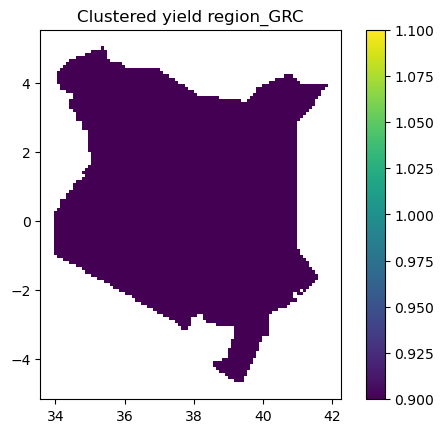

Enter the optimum number of clusters in normalized_region_TAI (or press Enter for default):  1


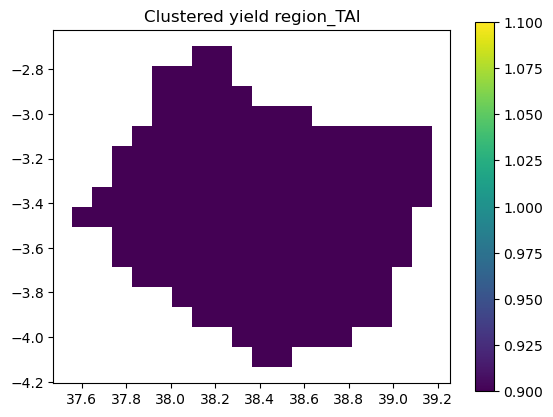

In [88]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=pd.core.common.SettingWithCopyWarning)
    
    # Choose optimum number of clusters
    default_cluster = 3  # Default number of clusters
    
    for i in regions_normalized_list:
        user_input = input("Enter the optimum number of clusters in {} (or press Enter for default): ".format(i))

        # Use the user input or the default value
        number_cluster = int(user_input.strip()) if user_input else default_cluster

        for j in regions_list:
            if j in i:
                # Perform agglomerative hierarchical clustering
                agglomerative_clustering (regions_gdf[j], regions_normalized_gdf[i] , number_cluster, j)


# Part 6: Statistics Calculation

This part calculates summary statistics for the generated clusters. There outputs include:

* Tabular summaries (.csv format) grouped by cluster

## 6.1. Calculating Cluster Summaries

In [89]:
#Collect Names of Attributes Assigned to the Clusters
origin_list_of_cols = list(final_clustered_GAEZ_gdf.columns)
final_list_of_cols = list(land_cells.columns)

In [90]:
# Land cover area estimator
def calc_LC_sqkm(df, col_list):
    """ 
    This function takes the df where the LC type for different classes is provided per location (row).
    It adds all pixels per location; then is calculates the ratio of LC class in each location (% of total).
    Finally is estimates the area per LC type in each location by multiplying with the total area each row represents.
    
    INPUT: 
    df -> Pandas dataframe with LC type classification 
    col_list -> list of columns to include in the summary (e.g. LC1-LC11)
    
    OUTPUT: Updated dataframe with estimated area (sqkm) of LC types per row
    """
    df["LC_sum"] = df[col_list].sum(axis=1)
    for col in col_list:
        df[col] = df[col]/df["LC_sum"]*df["sqkm"]
    
    return df


In [91]:
# Identify land cover related columns
landCover_cols = []
for col in final_list_of_cols:
    if "LCType" in col:
        landCover_cols.append(col)
if not landCover_cols:
    print ("There is not any Land Cover associated column in the dataframe; please revise")
else:
    pass

In [92]:
data_gdf_LCsqkm_list = []
data_gdf_LCsqkm = {}

for i in regions_list:
    data_gdf_LCsqkm_name = 'data_gdf_LCsqkm_'+ i
    data_gdf_LCsqkm_list.append(data_gdf_LCsqkm_name)
    data_gdf_LCsqkm [data_gdf_LCsqkm_name]= calc_LC_sqkm (regions_gdf[i], landCover_cols)

C:\Users\Ronny\anaconda3\envs\GeoCLEWs\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


## 6.2 Unit Conversion  

In [93]:
#new
# Calculate summary statistics for other than land cover attribute columns
data_gdf_stat = data_gdf_LCsqkm

# Define the conversion factor for CLEWs modelling
#Potential yield unit conversion from kg DW/ha to million tonnes per 1000 sqkm
factor1 = 0.0001 

#Other parameter unit conversion from millimeter to BCM per 1000 sqkm
factor2 = 0.001

for i in data_gdf_LCsqkm_list:
    for col in data_gdf_stat[i].columns:

        if "yld" in col:
            data_gdf_stat[i].loc[:, col] *= factor1
        elif "evt" in col: 
            data_gdf_stat[i].loc[:, col] *= factor2
        elif "prc" in col: 
            data_gdf_stat[i].loc[:, col] *= factor2
        elif "cwd" in col: 
            data_gdf_stat[i].loc[:, col] *= factor2     
    final_list_of_cols = list(data_gdf_stat[i].columns)


C:\Users\Ronny\anaconda3\envs\GeoCLEWs\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [94]:

sum_cols = [x for x in final_list_of_cols if x not in origin_list_of_cols]
sum_cols = [x for x in sum_cols if x not in landCover_cols]
sum_cols.remove("id")
sum_cols.remove("LC_sum")

## 6.3. Land Cover and Area Statistics

In [95]:
group_lc = {}

for key, gdf in data_gdf_stat.items():
    # Group by 'clusters_yield'
    clusters = gdf.groupby(['clusters_yield'])
    
    
    clusters_lc = clusters[landCover_cols].sum().merge(clusters["sqkm"].sum().reset_index(name="sqkm"), on="clusters_yield").round(decimals=1)
    clusters_lc = clusters_lc.sort_values(ascending=True, by='clusters_yield').reset_index(drop=True)
    name = key[-3:]
    
    #Export land cover stats to csv
    clusters_lc.to_csv(os.path.join(summary_stats_path,"{}_LandCover_byCluster_summary.csv".format(name)),index_label='cluster')

    # Display summary statistics
    display(Markdown('#### Cluster summary statistics for area and land cover in {}'.format(name)))
    display(Markdown(' **Total area:** {:0.1f} sq.km'.format(clusters_lc.sqkm.sum())))
    display(clusters_lc)

    # Store the result in the group_dic dictionary
    group_lc[key] = clusters_lc



#### Cluster summary statistics for area and land cover in GRC

 **Total area:** 569267.6 sq.km

,clusters_yield,LCType11,LCType10,LCType5,LCType7,LCType6,LCType3,LCType2,LCType8,LCType4,LCType1,LCType9,sqkm
0,1,12093.2,64115.6,22296.6,91086.6,53060.6,280696.8,23452.0,10666.2,9637.6,2037.5,125.0,569267.6


#### Cluster summary statistics for area and land cover in TAI

 **Total area:** 17144.9 sq.km

,clusters_yield,LCType11,LCType10,LCType5,LCType7,LCType6,LCType3,LCType2,LCType8,LCType4,LCType1,LCType9,sqkm
0,1,0.0,360.5,141.2,2373.5,448.4,13821.3,0.0,0.0,0.0,0.0,0.0,17144.9


### 6.4. Calculating the Average of Additional Crops

### 6.5. Other Variable Statistics

In [96]:
def additional_stat_group(parameter, year_range):
    selected_group = [col for col in additional_stat_table_group.columns if parameter in col]
    selected_group = additional_stat_table_group.loc[:, selected_group]

    if year_range == '1981-2010':
        relevant_cols = [col for col in selected_group.columns if '1981' in col or '1982' in col or '1983' in col or '1984' in col or '1985' in col or '1986' in col or '1987' in col or '1988' in col or '1989' in col or '1990' in col or '1991' in col or '1992' in col or '1993' in col or '1994' in col or '1995' in col or '1996' in col or '1997' in col or '1998' in col or '1999' in col or '2000' in col or '2001' in col or '2002' in col or '2003' in col or '2004' in col or '2005' in col or '2006' in col or '2007' in col or '2008' in col or '2009' in col or '2010' in col]
    elif year_range == '2011-2040':
        relevant_cols = [col for col in selected_group.columns if '2011' in col or '2012' in col or '2013' in col or '2014' in col or '2015' in col or '2016' in col or '2017' in col or '2018' in col or '2019' in col or '2020' in col or '2021' in col or '2022' in col or '2023' in col or '2024' in col or '2025' in col or '2026' in col or '2027' in col or '2028' in col or '2029' in col or '2030' in col or '2031' in col or '2032' in col or '2033' in col or '2034' in col or '2035' in col or '2036' in col or '2037' in col or '2038' in col or '2039' in col or '2040' in col]
    elif year_range == '2041-2070':
        relevant_cols = [col for col in selected_group.columns if '2041' in col or '2042' in col or '2043' in col or '2044' in col or '2045' in col or '2046' in col or '2047' in col or '2048' in col or '2049' in col or '2050' in col or '2051' in col or '2052' in col or '2053' in col or '2054' in col or '2055' in col or '2056' in col or '2057' in col or '2058' in col or '2059' in col or '2060' in col or '2061' in col or '2062' in col or '2063' in col or '2064' in col or '2065' in col or '2066' in col or '2067' in col or '2068' in col or '2069' in col or '2070' in col]
    elif year_range == '2071-2100':
        relevant_cols = [col for col in selected_group.columns if '2071' in col or '2072' in col or '2073' in col or '2074' in col or '2075' in col or '2076' in col or '2077' in col or '2078' in col or '2079' in col or '2080' in col or '2081' in col or '2082' in col or '2083' in col or '2084' in col or '2085' in col or '2086' in col or '2087' in col or '2088' in col or '2089' in col or '2090' in col or '2091' in col or '2092' in col or '2093' in col or '2094' in col or '2095' in col or '2096' in col or '2097' in col or '2098' in col or '2099' in col or '2100' in col]
    else:
        relevant_cols = []

    selected_group = selected_group[relevant_cols]

    if not selected_group.empty:
        Irrigation_Low_group = selected_group.loc[:, [a for a in selected_group.columns if 'Irrigation Low' in a]]
        Low_group = round(Irrigation_Low_group.mean(axis=1), 4)
        clusters_stat['OTH' + ' ' + parameter + ' ' + 'Irrigation Low_mean' + ' ' + year_range] = Low_group
        
        Irrigation_High_group = selected_group.loc[:, [a for a in selected_group.columns if 'Irrigation High' in a]]
        High_group = round(Irrigation_High_group.mean(axis=1), 4)
        clusters_stat['OTH' + ' ' + parameter + ' ' + 'Irrigation High_mean' + ' ' + year_range] = High_group

        Rain_fed_Low_group = selected_group.loc[:, [a for a in selected_group.columns if 'Rain-fed Low' in a]]
        Rain_Low = round(Rain_fed_Low_group.mean(axis=1), 4)
        clusters_stat['OTH' + ' ' + parameter + ' ' + 'Rain-fed Low_mean' + ' ' + year_range] = Rain_Low
                
        Rain_fed_High_group = selected_group.loc[:, [a for a in selected_group.columns if 'Rain-fed High' in a]]
        Rain_High = round(Rain_fed_High_group.mean(axis=1), 4)
        clusters_stat['OTH' + ' ' + parameter + ' ' + 'Rain-fed High_mean' + ' ' + year_range] = Rain_High
    else:
        print("No data available for the year range:", year_range)


In [97]:
group_stat = {}

for key, gdf in data_gdf_stat.items():
    # Group by 'clusters_yield'
    clusters = gdf.groupby(['clusters_yield'])
    
    clusters_stat = clusters[sum_cols].mean().round(decimals=4)

    # Extract additional columns related to other crops
    additional_crop_stat_group = [col for col in clusters_stat.columns if any(a in col for a in other_crop_name)]
    additional_stat_table_group = clusters_stat.loc[:, additional_crop_stat_group].copy()
    clusters_stat = clusters_stat.drop(additional_stat_table_group, axis=1)

    additional_stat_group('yld', '1981-2010')
    additional_stat_group('yld', '2011-2040')
    additional_stat_group('yld', '2041-2070')
    additional_stat_group('yld', '2071-2100')
    
    additional_stat_group('cwd', '1981-2010')
    additional_stat_group('cwd', '2011-2040')
    additional_stat_group('cwd', '2041-2070')
    additional_stat_group('cwd', '2071-2100')
    
    additional_stat_group('evt', '1981-2010')
    additional_stat_group('evt', '2011-2040')
    additional_stat_group('evt', '2041-2070')
    additional_stat_group('evt', '2071-2100')
    
    name = key[-3:]
    
    display(Markdown('#### Cluster summary statistics for other variables in {}'.format(name)))
    display(clusters_stat)

    group_stat[key] = clusters_stat


#### Cluster summary statistics for other variables in GRC

,SOR cwd Rain-fed Low_mean,SOR yld Rain-fed High 2011-2040_mean,MZE yld Rain-fed Low_mean,BEA yld Irrigation High 2011-2040_mean,SOR evt Rain-fed Low 1981-2010_mean,BEA yld Irrigation High_mean,SOR cwd Rain-fed High_mean,BEA cwd Rain-fed High 1981-2010_mean,BEA cwd Rain-fed High_mean,TEA cwd Irrigation Low 1981-2010_mean,...,OTH evt Rain-fed Low_mean 2011-2040,OTH evt Rain-fed High_mean 2011-2040,OTH evt Irrigation Low_mean 2041-2070,OTH evt Irrigation High_mean 2041-2070,OTH evt Rain-fed Low_mean 2041-2070,OTH evt Rain-fed High_mean 2041-2070,OTH evt Irrigation Low_mean 2071-2100,OTH evt Irrigation High_mean 2071-2100,OTH evt Rain-fed Low_mean 2071-2100,OTH evt Rain-fed High_mean 2071-2100
clusters_yield,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0


#### Cluster summary statistics for other variables in TAI

,SOR cwd Rain-fed Low_mean,SOR yld Rain-fed High 2011-2040_mean,MZE yld Rain-fed Low_mean,BEA yld Irrigation High 2011-2040_mean,SOR evt Rain-fed Low 1981-2010_mean,BEA yld Irrigation High_mean,SOR cwd Rain-fed High_mean,BEA cwd Rain-fed High 1981-2010_mean,BEA cwd Rain-fed High_mean,TEA cwd Irrigation Low 1981-2010_mean,...,OTH evt Rain-fed Low_mean 2011-2040,OTH evt Rain-fed High_mean 2011-2040,OTH evt Irrigation Low_mean 2041-2070,OTH evt Irrigation High_mean 2041-2070,OTH evt Rain-fed Low_mean 2041-2070,OTH evt Rain-fed High_mean 2041-2070,OTH evt Irrigation Low_mean 2071-2100,OTH evt Irrigation High_mean 2071-2100,OTH evt Rain-fed Low_mean 2071-2100,OTH evt Rain-fed High_mean 2071-2100
clusters_yield,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0


## 6.6. Generate clewsy-compatible Statistics

In [98]:
for key, gdf in group_stat.items():    
    clusters_other = gdf
    
    name = key[-3:]

    # generating the crop potential yeild csv files
    yld_columns = [col for col in clusters_other.columns if 'yld' in col]
    yld_df = clusters_other[yld_columns]

    # Name correction according clewsy format
    yld_rename = {col: col.replace(' yld', '').replace('_mean', '') for col in yld_df.columns}
    yld_df = yld_df.rename(columns=yld_rename)
    empty_yld = pd.DataFrame(columns=['', '', '', '','', '', '', '', ''],index= yld_df.index)
    combined_yld = pd.concat([empty_yld, yld_df], axis=1)

    #Store as CSV file
    combined_yld.to_csv(os.path.join(summary_stats_path,"clustering_results_{}.csv".format(name)), index= True, index_label='cluster')


    # generating crop evapotranspiration csv files
    evt_columns = [col for col in clusters_other.columns if 'evt' in col]
    evt_df = clusters_other[evt_columns]

    # Name correction
    evt_rename = {col: col.replace(' evt', '').replace('_mean', '') for col in evt_df.columns}
    evt_df = evt_df.rename(columns=evt_rename)
    empty_evt = pd.DataFrame(columns=['', '', '', '','', '', '', '', ''],index= evt_df.index)
    combined_evt = pd.concat([empty_evt, evt_df], axis=1)

    combined_evt.to_csv(os.path.join(summary_stats_path,"clustering_results_evt_{}.csv".format(name)), index= True, index_label='cluster')

    #generating crop water deficit csv files 
    cwd_columns = [col for col in clusters_other.columns if 'cwd' in col]
    cwd_df = clusters_other[cwd_columns]

    # Name correction
    cwd_rename = {col: col.replace(' cwd', '').replace('_mean', '') for col in cwd_df.columns}
    cwd_df = cwd_df.rename(columns=cwd_rename)
    empty_cwd = pd.DataFrame(columns=['', '', '', '','', '', '', '', ''],index= cwd_df .index)
    combined_cwd = pd.concat([empty_cwd, cwd_df], axis=1)

    combined_cwd.to_csv(os.path.join(summary_stats_path,"clustering_results_cwd_{}.csv".format(name)), index= True, index_label='cluster')


    # generating precipitation csv files
    prc_columns = [col for col in clusters_other.columns if 'prc' in col]
    prc_df = clusters_other[prc_columns]

    prc_rename = {col: col.replace(' prc', '').replace('_mean', '') for col in prc_df.columns}
    prc_df = prc_df.rename(columns=prc_rename)

    prc_df.to_csv(os.path.join(summary_stats_path,"clustering_results_prc_{}.csv".format(name)), index= True, index_label='cluster')


    #Export summary stats to csv
    clusters_other.to_csv(os.path.join(summary_stats_path,"{}_Parameter_byCluster_summary.csv".format(name)))


## Part 6.7: Interpolating the missing summary data
This part calculates missing summary data for the generated clusters. There outputs include:

* Evt, cwd and yld Low-Input data for both irrigated and Rain-fed crops in Tabular summaries (.csv format) grouped by cluster


## Part 6.8: Interpolation of Low-Input Data


In [99]:

import os
# Define the summary stats directory path with 'users'
summary_stats_path = r'C:\Users\Ronny\CLEWs_GAEZ\GAEZ_Processing\Data\output\summary_stats'  # Update this with your directory path

# List of prefixes to identify the columns
prefixes = ["TEA Irrigation", "TEA Rain-fed", "BEA Irrigation", "BEA Rain-fed",
            "COW Irrigation", "COW Rain-fed", "MZE Irrigation", "MZE Rain-fed",
            "SOR Irrigation", "SOR Rain-fed", "OTH Irrigation", "OTH Rain-fed"]

# Process each file in the directory
for file_name in os.listdir(summary_stats_path):
    if file_name.startswith("clustering_results"):
        file_path = os.path.join(summary_stats_path, file_name)
        print(f"Processing file: {file_path}")

        try:
            data = pd.read_csv(file_path)
        except pd.errors.EmptyDataError:
            print(f"Skipping empty file: {file_path}")
            continue

        # Process data
        for prefix in prefixes:
            low_1981_2010_columns = [col for col in data.columns if col.startswith(prefix) and col.endswith('Low 1981-2010')]
            high_1981_2010_columns = [col for col in data.columns if col.startswith(prefix) and col.endswith('High 1981-2010')]
            high_2011_2040_columns = [col for col in data.columns if col.startswith(prefix) and col.endswith('High 2011-2040')]
            high_2041_2070_columns = [col for col in data.columns if col.startswith(prefix) and col.endswith('High 2041-2070')]
            high_2071_2100_columns = [col for col in data.columns if col.startswith(prefix) and col.endswith('High 2071-2100')]

            # Ensure the lists are not empty before proceeding
            if not (low_1981_2010_columns and high_1981_2010_columns and high_2011_2040_columns and high_2041_2070_columns and high_2071_2100_columns):
                continue

            # Iterate over each set of columns
            for low_1981_2010_col, high_1981_2010_col, high_2011_2040_col, high_2041_2070_col, high_2071_2100_col in zip(
                    low_1981_2010_columns, high_1981_2010_columns, high_2011_2040_columns, high_2041_2070_columns, high_2071_2100_columns):

                # Create corresponding "low" column names for future periods
                low_2011_2040_col = high_2011_2040_col.replace('High', 'Low')
                low_2041_2070_col = high_2041_2070_col.replace('High', 'Low')
                low_2071_2100_col = high_2071_2100_col.replace('High', 'Low')

                # Calculate the percentage change for each row based on the 1981-2010 period
                percentage_change = abs((data[high_1981_2010_col] - data[low_1981_2010_col]) / data[low_1981_2010_col])

                # Apply the percentage change to forecast "Low" for each row
                data[low_2011_2040_col] = data[high_2011_2040_col] / (1 + percentage_change)
                data[low_2041_2070_col] = data[high_2041_2070_col] / (1 + percentage_change)
                data[low_2071_2100_col] = data[high_2071_2100_col] / (1 + percentage_change)

        # Empty columns 2 to 10 if it's not the specific file
        if not file_name.startswith("clustering_results_prc"):
            for i in range(1, 10):
                data.iloc[:, i] = ""

            # Setting column headers to empty strings for columns 2 to 10
            data.columns = [data.columns[0]] + [""] * 9 + data.columns[10:].tolist()

        # Save the processed data into the original file, ensuring all columns are retained
        data.to_csv(file_path, index=False)
        print(f"Processed data saved to: {file_path}")


Processing file: C:\Users\Ronny\CLEWs_GAEZ\GAEZ_Processing\Data\output\summary_stats\clustering_results_cwd_GRC.csv
Processed data saved to: C:\Users\Ronny\CLEWs_GAEZ\GAEZ_Processing\Data\output\summary_stats\clustering_results_cwd_GRC.csv
Processing file: C:\Users\Ronny\CLEWs_GAEZ\GAEZ_Processing\Data\output\summary_stats\clustering_results_cwd_TAI.csv
Processed data saved to: C:\Users\Ronny\CLEWs_GAEZ\GAEZ_Processing\Data\output\summary_stats\clustering_results_cwd_TAI.csv
Processing file: C:\Users\Ronny\CLEWs_GAEZ\GAEZ_Processing\Data\output\summary_stats\clustering_results_evt_GRC.csv
Processed data saved to: C:\Users\Ronny\CLEWs_GAEZ\GAEZ_Processing\Data\output\summary_stats\clustering_results_evt_GRC.csv
Processing file: C:\Users\Ronny\CLEWs_GAEZ\GAEZ_Processing\Data\output\summary_stats\clustering_results_evt_TAI.csv
Processed data saved to: C:\Users\Ronny\CLEWs_GAEZ\GAEZ_Processing\Data\output\summary_stats\clustering_results_evt_TAI.csv
Processing file: C:\Users\Ronny\CLEWs_GA

## 6.9: Final Land Cover statistics by parameter

In [100]:

import glob

# Directory where your CSV files are located
directory = r'C:\Users\Ronny\CLEWs_GAEZ\GAEZ_Processing\Data\output\summary_stats'  # Update this with your directory path

# Identify CSV files
clustering_yld_files = glob.glob(os.path.join(directory, "clustering_results*.csv"))
clustering_cwd_files = glob.glob(os.path.join(directory, "clustering_results_cwd*.csv"))
clustering_evt_files = glob.glob(os.path.join(directory, "clustering_results_evt*.csv"))
summary_files = glob.glob(os.path.join(directory, "*Parameter_byCluster_Summary.csv"))

# Function to generate new column names
def generate_new_column_name(old_name, suffix):
    parts = old_name.split()
    return f"{parts[0]} {suffix} {' '.join(parts[1:])}_mean"

# Function to filter out columns with empty cells
def filter_empty_columns(df):
    return df.dropna(axis=1, how='all')

# Process clustering files for yld, cwd, and evt
for clustering_files, suffix in zip([clustering_yld_files, clustering_cwd_files, clustering_evt_files], ['yld', 'cwd', 'evt']):
    for clustering_file in clustering_files:
        #print(f"Processing clustering file: {clustering_file}")
        
        # Extract the last name from the clustering file name
        clustering_last_name = os.path.splitext(os.path.basename(clustering_file))[0].split("_")[-1]
        
        # Find the corresponding summary file based on the last name
        matching_summary_files = [f for f in summary_files if clustering_last_name in os.path.basename(f)]
        
        # Continue processing only if matching summary files are found
        if matching_summary_files:
            for summary_file in matching_summary_files:
                #print(f"Corresponding summary file: {summary_file}")
                
                # Read the clustering file into a DataFrame
                clustering_df = pd.read_csv(clustering_file)
                
                # Read the summary file into a DataFrame
                summary_df = pd.read_csv(summary_file)
                
                # List of column prefixes to identify
                column_prefixes = list(set(col.split()[0] for col in clustering_df.columns))
                
                # Check matching columns and add missing columns to summary DataFrame
                for col_prefix in column_prefixes:
                    # Find corresponding columns in clustering DataFrame
                    clustering_cols = [col for col in clustering_df.columns if col.startswith(col_prefix)]
                    
                    # Check if the columns already exist in the summary DataFrame
                    for clustering_col in clustering_cols:
                        if clustering_col not in summary_df.columns:
                            new_col_name = generate_new_column_name(clustering_col, suffix)
                            #print(f"Adding missing column: {new_col_name}")
                            summary_df[new_col_name] = clustering_df[clustering_col]
                
                # Filter out columns with empty cells
                summary_df_filtered = filter_empty_columns(summary_df)
                
                # Save the updated summary DataFrame back to the original file
                summary_df_filtered.to_csv(summary_file, index=False)
                #print(f"Updated summary file saved: {summary_file}")
        else:
            #print(f"No matching summary file found for {clustering_file}")
            pass


## 6.10: User Input for Time Period
Filter Summary Data Based on Simulation Period for CLEWs Modelling

In [101]:
import pandas as pd
import os
# Load your CSV file
def load_data(file_path):
    return pd.read_csv(file_path)

# Clean column headings by removing the specified period
def clean_column_headings(columns):
    periods = ['1981-2010', '2011-2040', '2041-2070', '2071-2100']
    cleaned_columns = []
    for col in columns:
        # Remove any period from column name
        for period in periods:
            col = col.replace(period, '').strip()
        cleaned_columns.append(col)
    return cleaned_columns

# Filter data based on user input
def filter_data(df, choice, is_param_file):
    # Define filtering criteria
    columns = {
        '1': '1981-2010',
        '2': '2011-2040',
        '3': '2041-2070',
        '4': '2071-2100'
    }
    
    if choice in columns:
        keyword = columns[choice]
        filtered_columns = [col for col in df.columns[10:] if keyword in col]  # Filter from column 11 onwards
        filtered_df = df.iloc[:, [0]].join(df[filtered_columns])  # Keep column 1 and join the filtered columns
        
        # Clean the column headings
        cleaned_columns = clean_column_headings(filtered_df.columns)
        filtered_df.columns = cleaned_columns
        
        if not is_param_file:
            # Create empty columns for non-parameter files
            empty_columns = pd.DataFrame('', index=filtered_df.index, columns=[f'Empty_{i+1}' for i in range(9)])
            filtered_df = pd.concat([filtered_df.iloc[:, [0]], empty_columns, filtered_df.iloc[:, 1:]], axis=1)
            filtered_df.iloc[:, 1:10] = ''  # Ensure columns 2 to 10 are empty
            # Remove headers for empty columns
            filtered_df.columns = filtered_df.columns[:1].tolist() + [''] * 9 + filtered_df.columns[10:].tolist()
        
        return filtered_df
    else:
        print("Invalid choice.")
        return None

# Save the filtered data to the same CSV file
def save_data(df, file_path):
    df.to_csv(file_path, index=False)

# Main function
def main():
    directory_path = r'C:\Users\Ronny\CLEWs_GAEZ\GAEZ_Processing\Data\output\summary_stats'  # Update this with your directory path
    
    # Prompt user for input
    print("Enter 1 for data from 1981 to 2010")
    print("Enter 2 for data from 2011 to 2040")
    print("Enter 3 for data from 2041 to 2070")
    print("Enter 4 for data from 2071 to 2100")
    
    choice = input("Your choice: ")
    
    # Iterate over all CSV files in the directory
    for file_path in glob.glob(os.path.join(directory_path, '*.csv')):
        file_name = os.path.basename(file_path)
        
        # Exclude specific files from filtering
        if (file_name.startswith('clustering_results_prc') or
            file_name.endswith('LandCover_byCluster_summary.csv')):
            print(f"Skipping file: {file_path}")
            continue
        
        # Determine if the file is a 'Parameter_byCluster_summary.csv' file
        is_param_file = file_name.endswith('Parameter_byCluster_summary.csv')
        
        if not is_param_file:
            print(f"Processing file: {file_path}")
            
            # Load data
            df = load_data(file_path)
            if df is None:
                continue
            
            # Filter data
            filtered_df = filter_data(df, choice, False)
            if filtered_df is not None:
                save_data(filtered_df, file_path)
                print(f"Filtered data saved to {file_path}")
        else:
            print(f"Processing parameter file: {file_path}")
            
            # Load data
            df = load_data(file_path)
            if df is None:
                continue
            
            # Filter data
            filtered_df = filter_data(df, choice, True)
            if filtered_df is not None:
                save_data(filtered_df, file_path)
                print(f"Filtered parameter data saved to {file_path}")

if __name__ == "__main__":
    main()

Enter 1 for data from 1981 to 2010
Enter 2 for data from 2011 to 2040
Enter 3 for data from 2041 to 2070
Enter 4 for data from 2071 to 2100


Your choice:  2


Processing file: C:\Users\Ronny\CLEWs_GAEZ\GAEZ_Processing\Data\output\summary_stats\clustering_results_cwd_GRC.csv
Filtered data saved to C:\Users\Ronny\CLEWs_GAEZ\GAEZ_Processing\Data\output\summary_stats\clustering_results_cwd_GRC.csv
Processing file: C:\Users\Ronny\CLEWs_GAEZ\GAEZ_Processing\Data\output\summary_stats\clustering_results_cwd_TAI.csv
Filtered data saved to C:\Users\Ronny\CLEWs_GAEZ\GAEZ_Processing\Data\output\summary_stats\clustering_results_cwd_TAI.csv
Processing file: C:\Users\Ronny\CLEWs_GAEZ\GAEZ_Processing\Data\output\summary_stats\clustering_results_evt_GRC.csv
Filtered data saved to C:\Users\Ronny\CLEWs_GAEZ\GAEZ_Processing\Data\output\summary_stats\clustering_results_evt_GRC.csv
Processing file: C:\Users\Ronny\CLEWs_GAEZ\GAEZ_Processing\Data\output\summary_stats\clustering_results_evt_TAI.csv
Filtered data saved to C:\Users\Ronny\CLEWs_GAEZ\GAEZ_Processing\Data\output\summary_stats\clustering_results_evt_TAI.csv
Processing file: C:\Users\Ronny\CLEWs_GAEZ\GAEZ_

In [102]:
print ("Part 6 - and with that the analysis - completed!")
print ("Total elapsed time: {}".format(time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))))

Part 7 - and with that the analysis - completed!
Total elapsed time: 13:45:53
